In [1]:
import random
import numpy as np
from qiskit import transpile, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
def DJAlgorithm(oracle, nInput):
    circ = QuantumCircuit(nInput + 1, nInput)
    
    circ.x(nInput)

    for q in range(nInput + 1):
        circ.h(q)

    circ.append(oracle, range(nInput + 1))

    for q in range(nInput):
        circ.h(q)

    for q in range(nInput):
        circ.measure(q, q)

    return circ

In [3]:
def DJOracle(case, n):    # --- from IBM ---
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)

    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1, 2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"  # To show when we display the circuit
    return oracle_gate

In [4]:
nInput = 8

case = random.choice(("balanced", "constant"))
print("Case is " + case)

oracleGate = DJOracle(case, nInput)

circ = DJAlgorithm(oracleGate, nInput)

circ.draw()

Case is balanced


┌───┐     ┌─────────┐┌───┐┌─┐                     
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────────────────
     ├───┤     │         │├───┤└╥┘┌─┐                  
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────────────────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐               
q_2: ┤ H ├─────┤2        ├┤ H ├─╫──╫─┤M├───────────────
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐            
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├────────────
     ├───┤     │         │├───┤ ║  ║  ║ └╥┘┌─┐         
q_4: ┤ H ├─────┤4 Oracle ├┤ H ├─╫──╫──╫──╫─┤M├─────────
     ├───┤     │         │├───┤ ║  ║  ║  ║ └╥┘┌─┐      
q_5: ┤ H ├─────┤5        ├┤ H ├─╫──╫──╫──╫──╫─┤M├──────
     ├───┤     │         │├───┤ ║  ║  ║  ║  ║ └╥┘┌─┐   
q_6: ┤ H ├─────┤6        ├┤ H ├─╫──╫──╫──╫──╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_7: ┤ H ├─────┤7        ├┤ H ├─╫──╫──╫──╫──╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
q_8: ┤ X ├┤ H ├┤8        ├──────╫──╫──╫──╫──╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║  ║  ║  ║  ║ 
c: 8/═══════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                0  1  2  3  4  5  6  7

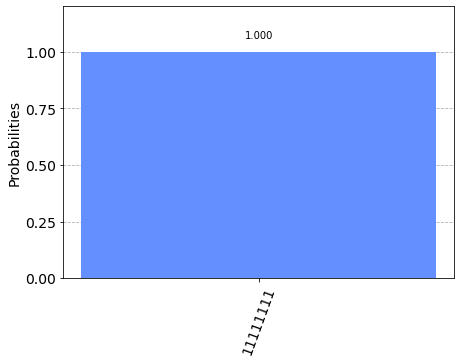

In [5]:
backend = AerSimulator()

circ_compiled = transpile(circ, backend)

job_sim = backend.run(circ_compiled, shots=1024)

result_sim = job_sim.result()
counts = result_sim.get_counts(circ_compiled)

plot_histogram(counts)